In [1]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import time
import matplotlib.pyplot as plt

## Input Testing code:

In [ ]:
# cap =  cv2.VideoCapture(0, cv2.CAP_DSHOW)     # UNCOMMENT THIS LINE FOR WINDOWS
cap =  cv2.VideoCapture(0)                     # UNCOMMENT THIS LINE FOR LINUX

ref_img = False 

while cap.isOpened():
    
    success, frame_img = cap.read()
    # frame = cv2.rotate(frame, cv2.ROTATE_180)

    if not success:
        print("Ignoring empty camera frame.")
        break

    if not ref_img:    
        cv2.imshow('Pressed Key Frame', frame_img)
        
        if cv2.waitKey(1) & 0xFF == ord('s'):
            break

    cv2.waitKey(1)
    if cv2.getWindowProperty('Pressed Key Frame', cv2.WND_PROP_VISIBLE) < 1:
        break
    
cap.release()
cv2.destroyAllWindows()

In [2]:
cap =  cv2.VideoCapture('output_no_press.mp4')
ref_img_test = None

while cap.isOpened():
    
    success, frame_img = cap.read()
    # frame = cv2.rotate(frame, cv2.ROTATE_180)

    if not success:
        print("Ignoring empty camera frame.")
        break

    if ref_img_test is None:    
        ref_img_test = frame_img
    
    cv2.imshow('Pressed Key Frame', frame_img)
    
    if cv2.waitKey(1) & 0xFF == ord('s'):
        break

    cv2.waitKey(1)
    if cv2.getWindowProperty('Pressed Key Frame', cv2.WND_PROP_VISIBLE) < 1:
        break
    
cap.release()
cv2.destroyAllWindows()

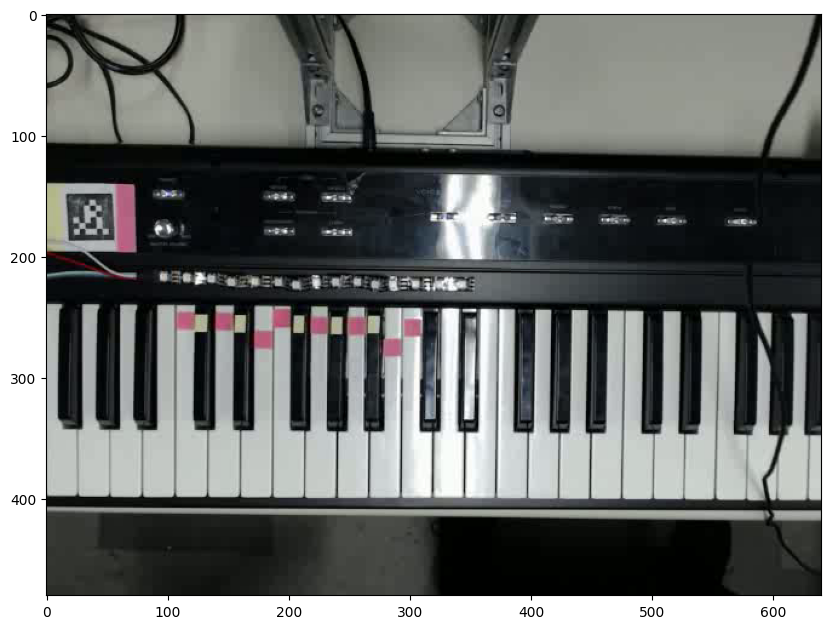

In [3]:
if ref_img_test is not None:
    ref_img_test = cv2.cvtColor(ref_img_test, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10,10))
    plt.imshow(ref_img_test)
else:
    print("No reference image found")

In [4]:
ref_img_hsv = cv2.cvtColor(ref_img_test, cv2.COLOR_RGB2HSV)

## Color Picker code:

In [ ]:
# # Initialize blank images for color exploration and selection
# color_explore = np.zeros((150, 150, 3), dtype=np.uint8)
# color_selected = np.zeros((150, 150, 3), dtype=np.uint8)

# # Mouse callback function for showing color under cursor and selected color
# def show_color(event, x, y, flags, param):
    
#     # Extract color components from the image at cursor position
#     B, G, R = img[y, x]

#     # Update color_explore with the color under cursor
#     color_explore[:] = (B, G, R)

#     # If left mouse button pressed, update color_selected and print the color values
#     if event == cv2.EVENT_LBUTTONDOWN:
#         color_selected[:] = (B, G, R)
#         black = (B, G, R)
#         print(black)

# # Create windows for color exploration and selected color display
# cv2.namedWindow('color_explore')
# cv2.resizeWindow('color_explore', 50, 50)

# cv2.namedWindow('color_selected')
# cv2.resizeWindow('color_selected', 50, 50)

# # Create window for displaying the sample image
# cv2.namedWindow('image')

# # Path to the sample image
# img = frame_img

# # Assign the mouse callback function to the 'image' window
# cv2.setMouseCallback('image', show_color)

# # Main loop for live update of the color exploration and selection
# while True:
#     cv2.imshow('image', img)
#     cv2.imshow('color_explore', color_explore)
#     cv2.imshow('color_selected', color_selected)

#     # Break the loop if 'Esc' key is pressed
#     if cv2.waitKey(1) & 0xFF == 27:
#         break

# # Clean up windows
# cv2.destroyAllWindows()


## Clustering as Numpy Arrays

In [5]:
def apply_threshold_hsv(roi, hsv_color, threshold_h=10, threshold_s=35, threshold_v=80):
    """Apply color thresholding in HSV color space to isolate specific color ranges in the ROI."""
    
    lower_bound = np.array([max(0, hsv_color[0] - threshold_h), max(0, hsv_color[1] - threshold_s), max(0, hsv_color[2] - threshold_v)])
    upper_bound = np.array([min(180, hsv_color[0] + threshold_h), min(255, hsv_color[1] + threshold_s), min(255, hsv_color[2] + threshold_v)])
    mask = cv2.inRange(roi, lower_bound, upper_bound)
    return mask


def find_clusters(ref_img_hsv, hsv_color=(174, 131, 201), min_size_threshold=10, max_size_threshold=300):
    """
    Find clusters of points in an image based on a given HSV color.

    Parameters:
    - ref_img_hsv (numpy.ndarray): The input image in HSV color space.
    - hsv_color (tuple): The target HSV color to find clusters around. Default is (174, 131, 201).
    - min_size_threshold (int): The minimum size threshold for a cluster to be considered. Default is 10.
    - max_size_threshold (int): The maximum size threshold for a cluster to be considered. Default is 300.

    Returns:
    - numpy.ndarray: An array of filtered clusters, where each cluster is represented as an array of points.

    Note:
    - The input image should be in HSV color space.
    - The returned clusters are filtered based on their size, where the size is determined by the number of points in the cluster.
    """
    
    mask = apply_threshold_hsv(ref_img_hsv, hsv_color)
    
    y_coord, x_coord = np.where(mask != 0)
    if len(y_coord) == 0:
        return np.array([])  # Return an empty numpy array if no points found
    
    coord_array = np.stack((x_coord, y_coord), axis=-1)
    dbscan = DBSCAN(eps=5, min_samples=min_size_threshold)
    clusters = dbscan.fit_predict(coord_array)

    # Filter clusters based on size
    filtered_cluster_list = []
    for cluster_idx in np.unique(clusters):
        if cluster_idx != -1:
            cluster_points = coord_array[clusters == cluster_idx]
            if min_size_threshold <= len(cluster_points) <= max_size_threshold:
                filtered_cluster_list.append(cluster_points)
    return np.array(filtered_cluster_list, dtype=object)


def arrange_clusters(filtered_cluster_list):
    """
    Arrange clusters from left to right based on their mean x-coordinate.
    
    Parameters:
    - filtered_cluster_list: numpy.ndarray
        An array of filtered clusters, where each cluster is represented by an array of points.
        
    Returns:
    - numpy.ndarray
        An array of clusters sorted from left to right.
    """
    if len(filtered_cluster_list) == 0:
        return filtered_cluster_list  # Return the empty array if no clusters

    # Calculate the mean x-coordinate for each cluster
    mean_x_coords = [np.mean(cluster[:, 0]) for cluster in filtered_cluster_list]
    
    # Sort the clusters based on their mean x-coordinate
    sorted_indices = np.argsort(mean_x_coords)
    
    # Reorder the clusters based on the sorted indices
    sorted_clusters = filtered_cluster_list[sorted_indices]

    return sorted_clusters

### VISUALIZATION

8
108 248 14 12
140 248 14 13
172 264 16 12
188 246 14 13
219 252 13 12
250 252 12 12
278 270 14 12
296 254 12 12


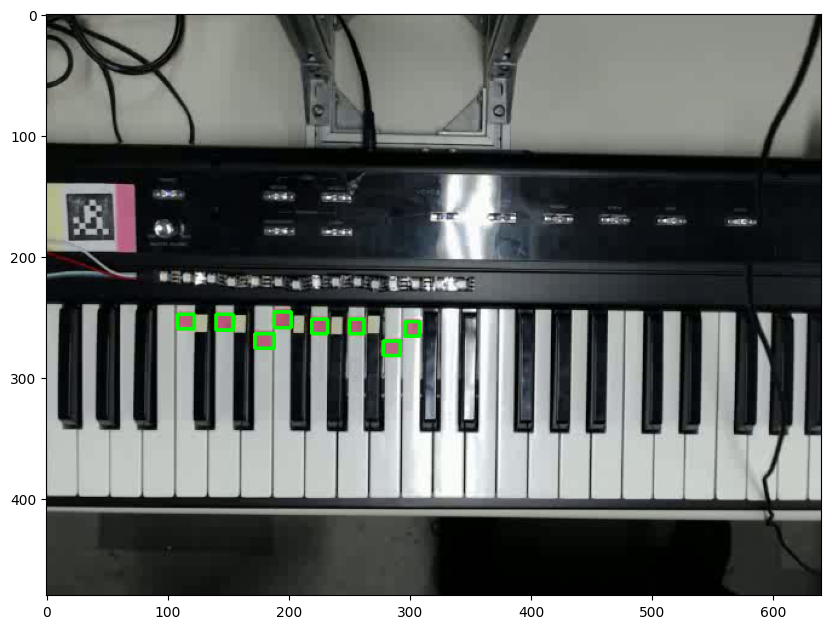

In [6]:
import matplotlib.patches as patches

def plot_clusters_on_image(clusters):
    """
    Plot an image and draw green bounding boxes with labels over the clusters.
    """
    tmp = ref_img_test.copy()
    
    for cluster in clusters:
        x, y, w, h = cv2.boundingRect(cluster)
        print(x, y, w, h)
        cv2.rectangle(tmp, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
    plt.figure(figsize=(10,10))
    plt.imshow(tmp)
    plt.show()
    

clusters = find_clusters(ref_img_hsv, hsv_color=(174, 131, 201), min_size_threshold=50, max_size_threshold=200)
print(len(clusters))
clusters = arrange_clusters(clusters)
if len(clusters) > 0:
    plot_clusters_on_image(clusters)


In [7]:
def calculate_centroids(filtered_cluster_list):
    """
    Calculate the centroids of filtered clusters.

    Parameters:
    - filtered_cluster_list: numpy.ndarray
        An array of filtered clusters, where each cluster is represented by an array of points.
        
    Returns:
    - list
        A list of centroids of the clusters.
    """
    centroids = []
    for cluster in filtered_cluster_list:
        centroid_x = np.mean(cluster[:, 0])
        centroid_y = np.mean(cluster[:, 1])
        centroids.append((centroid_x, centroid_y))
    return centroids


print(calculate_centroids(clusters))

[(114.25373134328358, 253.38805970149255), (146.00666666666666, 253.80666666666667), (178.70731707317074, 269.3048780487805), (193.83544303797467, 251.7594936708861), (225.29323308270676, 257.34586466165416), (256.35897435897436, 257.6923076923077), (285.4351145038168, 275.5419847328244), (302.03636363636366, 259.3727272727273)]


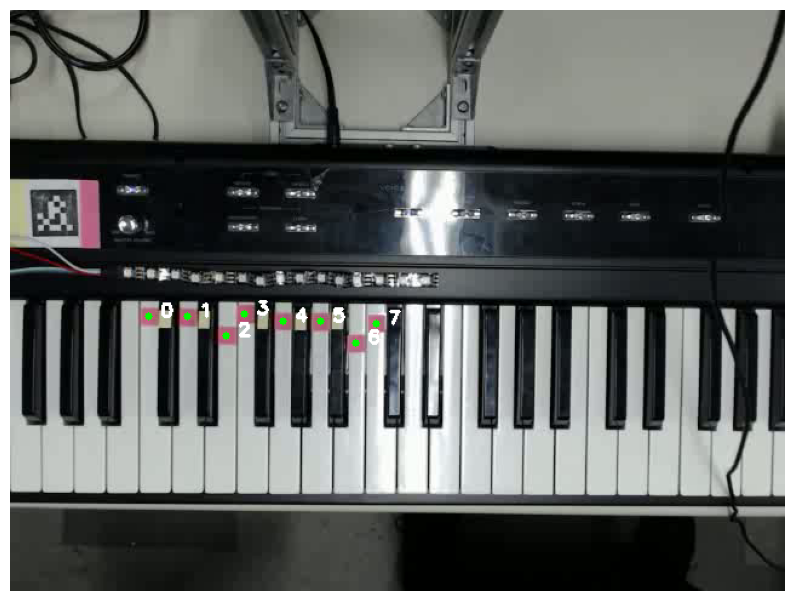

In [8]:
def plot_centroids_on_image(centroids, image):
    """
    Plot an image and draw a green dot at each centroid.
    
    Parameters:
    - centroids: list of tuples
        A list of coordinates representing the centroid of each cluster.
    - image: numpy.ndarray
        The image on which to plot the centroids.
    """
    tmp = image.copy()
    
    for idx, (cx, cy) in enumerate(centroids):
        # Draw a green dot at the centroid
        cv2.circle(tmp, (int(cx), int(cy)), 3, (0, 255, 0), -1)
        # Put the cluster index number next to the dot
        cv2.putText(tmp, str(idx), (int(cx) + 10, int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (255, 255, 255), 2)
    
    plt.figure(figsize=(10,10))
    plt.imshow(tmp)
    plt.axis('off')  # Hide the axis
    plt.show()
    
plot_centroids_on_image(calculate_centroids(clusters), ref_img_test)

In [11]:
cap =  cv2.VideoCapture('output_no_press.mp4')
ref_img_hsv = None
ref_centroids = None

while cap.isOpened():
    
    success, frame_img = cap.read()
    # frame = cv2.rotate(frame, cv2.ROTATE_180)

    if not success:
        print("Ignoring empty camera frame.")
        break

    if ref_img_hsv is None:    
        ref_img_hsv = cv2.cvtColor(frame_img, cv2.COLOR_BGR2HSV)
        ref_clusters = find_clusters(ref_img_hsv, hsv_color=(174, 131, 201), min_size_threshold=50, max_size_threshold=200) 
        ref_clusters = arrange_clusters(ref_clusters)
        ref_centroids = calculate_centroids(ref_clusters)
    else:
        inference_img_hsv = cv2.cvtColor(frame_img, cv2.COLOR_BGR2HSV)
        inference_clusters = find_clusters(inference_img_hsv, hsv_color=(174, 131, 201), min_size_threshold=50, max_size_threshold=200)
        inference_clusters = arrange_clusters(inference_clusters)
        inference_centroids = calculate_centroids(inference_clusters)
        print(len(inference_centroids))
        if len(inference_centroids) == len(ref_centroids):
            average_shift = calculate_average_centroid_shift(ref_centroids, inference_centroids)
            print(average_shift)
    
    cv2.imshow('Pressed Key Frame', frame_img)
    
    if cv2.waitKey(1) & 0xFF == ord('s'):
        break

    cv2.waitKey(1)
    if cv2.getWindowProperty('Pressed Key Frame', cv2.WND_PROP_VISIBLE) < 1:
        break
    
cap.release()
cv2.destroyAllWindows()

8
0.28251432641445245
8
0.291254230466506
8
0.31460296924007464
8
0.30999273748915757
8
0.2961663062608874
8
0.31206823768868847
8
0.34103080607720654
8
0.36428182792704455
8
0.3828087006554066
8
0.391988092158508
8
0.40155295143373443
8
0.4473942599785961
8
0.44792747657447274
8
0.46500173704330916
8
0.46500173704330916
8
0.46500173704330916
8
0.4827720999120848
8
0.4885733200800434
8
0.4885733200800434
8
0.48302376296256816
8
0.4486032181450612
8
0.4486032181450612
8
0.4486032181450612
8
0.3919854906153975
8
0.3919854906153975
8
0.38851861062584087
8
0.39504253603812145
8
0.39041863180614256
8
0.39041863180614256
8
0.38721427271090736
8
0.39446277386857237
8
0.40104054532544964
8
0.41471149909033006
8
0.41606696661795184
8
0.4183981972378084
8
0.4049555225497345
8
0.39536481786552546
8
0.39890263506918927
8
0.39890263506918927
8
0.40210023332658296
8
0.40210023332658296
8
0.40210023332658296
8
0.3985100745583391
8
0.3985100745583391
8
0.40302032866189197
8
0.39209624073028504
8
0.405